In [3]:
from subprocess import Popen, PIPE

#targ_file = '/Volumes/bioc1301/data/20190221_NMJ_culture_sggYFP_stability/aligned/20190221_sggYFP_24hr_culture_intact_p1s3l.tif'
#ref_file = '/Volumes/bioc1301/data/20190221_NMJ_culture_sggYFP_stability/aligned/20190221_sggYFP_24hr_culture_intact_p1s3l_calibration.tif'
#process = Popen(['chromagnon', 'targ_file', '-R', 'ref_file', '-E', 'dv'], stdout=PIPE, stderr=PIPE)
process = Popen(['chromagnon', '-h'], stdout=PIPE, stderr=PIPE)
stdout, stderr = process.communicate()
print stdout

usage: chromagnon target1 target2 -R reference1 reference2 [options]

Chromagnon is an adaptive channel alignment program for fluorescnece
microscope images. If no image file is supplied, a GUI will open to feed
multiple files. If you supply image file, the program starts as a console
program. When you have mutiple reference files, do like the 'usage':

positional arguments:
  targets               target images files

optional arguments:
  -h, --help            show this help message and exit
  --version, -v         show program's version number and exit
  --reference [REFERENCE [REFERENCE ...]], -R [REFERENCE [REFERENCE ...]]
                        reference image or chromagnon files (required)
  --local {None,Projection}, -l {None,Projection}
                        choose from ['None', 'Projection'] (default=None)
  --localMinWindow {30,60,120,240}, -w {30,60,120,240}
                        choose from ['30', '60', '120', '240'] (default=60)
  --maxShift MAXSHIFT, -s MAXSHIFT
   

In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

## Copyright (C) 2018 David Pinto <david.pinto@bioch.ox.ac.uk>
##
## This program is free software: you can redistribute it and/or modify
## it under the terms of the GNU General Public License as published by
## the Free Software Foundation, either version 3 of the License, or
## (at your option) any later version.
##
## This program is distributed in the hope that it will be useful,
## but WITHOUT ANY WARRANTY; without even the implied warranty of
## MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
## GNU General Public License for more details.
##
## You should have received a copy of the GNU General Public License
## along with this program.  If not, see <http://www.gnu.org/licenses/>.

import os.path
import pickle
import subprocess
import sys

from PyQt5 import QtWidgets


LABELS = ('yes', 'no', 'unsure')
DEFAULT_LABEL = 'unsure'

class Questionnaire(QtWidgets.QWidget):
    default_label_idx = LABELS.index(DEFAULT_LABEL)

    def __init__(self, questions, *args, **kwargs):
        super(Questionnaire, self).__init__(*args, **kwargs)
        self.questions = questions
        self.answers = [None] * len(questions)
        self.set_ui()

    def set_ui(self):
        grid_box = QtWidgets.QGroupBox()
        grid = QtWidgets.QGridLayout()

        ## Header
        for i, label in enumerate(LABELS):
            grid.addWidget(QtWidgets.QLabel(label), 0, i+1)

        ## Questions/Answers
        for i, question in enumerate(self.questions):
            grid.addWidget(QtWidgets.QLabel(question), i+1, 0)

            self.answers[i] = QtWidgets.QButtonGroup(parent=self)
            for j in range(len(LABELS)):
                button = QtWidgets.QRadioButton(parent=self)
                if j == Questionnaire.default_label_idx:
                    button.setChecked(True)
                ## Manually set id with the index for labels list.
                self.answers[i].addButton(button, id=j)
                grid.addWidget(button, i+1 , j+1)

        self.setLayout(grid)

    def to_serializable(self):
        results = dict()
        for question, answer in zip(self.questions, self.answers):
            results[question] = LABELS[answer.checkedId()]
        return results

    def reset(self):
        for answer in self.answers:
            answer.button(Questionnaire.default_label_idx).setChecked(True)


class QuestionWindow(QtWidgets.QWidget):
    def __init__(self, questions, answers_dir, img_fpaths,
                 *args, **kwargs):
        super(QuestionWindow, self).__init__(*args, **kwargs)
        self.setWindowTitle('Blind Questions')

        self.answers_dir = answers_dir
        self.img_fpaths = img_fpaths
        self.current_img = 0

        if len(img_fpaths) < 1:
            raise RuntimeError('no images to question')

        open_button = QtWidgets.QPushButton('Open in Viewer', parent=self)
        open_button.clicked.connect(self.open_image)

        self.questionnaire = Questionnaire(questions, parent=self)

        save_button = QtWidgets.QPushButton('save and next', parent=self)
        save_button.clicked.connect(self.save_and_next)

        layout = QtWidgets.QVBoxLayout()
        layout.addWidget(open_button)
        layout.addWidget(self.questionnaire)
        layout.addWidget(save_button)
        self.setLayout(layout)

    def open_image(self):
        fig_file = self.img_fpaths[self.current_img]
        args = ['xdg-open', fig_file]
        status = subprocess.call(args, shell=False)
        if status != 0:
            error_dialog = QtWidgets.QErrorMessage(parent=self)
            error_dialog.setModal(True)
            error_dialog.showMessage("failed to call %s" % args)

    def save_and_next(self):
        fig_file = self.img_fpaths[self.current_img]
        fname = os.path.splitext(os.path.basename(fig_file))[0]
        fpath = os.path.join(self.answers_dir, fname + '.pickle')
        if os.path.exists(fpath):
            raise RuntimeError('file already exists, do not overwrite results')
        with open(fpath, 'wb') as fh:
            pickle.dump(self.questionnaire.to_serializable(), fh)

        self.next_image()

    def next_image(self):
        self.questionnaire.reset()
        self.current_img +=1
        if not self.current_img < len(self.img_fpaths):
            error_dialog = QtWidgets.QErrorMessage(parent=self)
            error_dialog.setModal(True)
            error_dialog.showMessage("This is the end.")
            error_dialog.exec_()
            QtWidgets.qApp.quit()


if __name__ == '__main__':
    app = QtWidgets.QApplication(sys.argv)

    questions_fpath = sys.argv[1]
    questions = [l.strip() for l in open(questions_fpath, 'r').readlines()]

    answers_dir = sys.argv[2]

    img_fpaths = sys.argv[3:]

    window = QuestionWindow(questions, answers_dir, img_fpaths)
    window.show()
    sys.exit(app.exec_())


IOError: [Errno 2] No such file or directory: '-f'

In [ ]:
    def open_image(self):
        fig_file = self.img_fpaths[self.current_img]
        args = ['xdg-open', fig_file]
        status = subprocess.call(args, shell=False)
        if status != 0:
            error_dialog = QtWidgets.QErrorMessage(parent=self)
            error_dialog.setModal(True)
            error_dialog.showMessage("failed to call %s" % args)

In [2]:
import sys
#!{sys.executable} -m pip install numpy
!conda install --yes --prefix {sys.prefix} pyqt



Vendor:  continuum
Product: anaconda
Message: trial mode expires in 20 days
//anaconda/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.6.2
  latest version: 4.6.14

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: //anaconda/envs/chromagnon

  added / updated specs:
    - pyqt


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    dbus-1.13.6                |       h2f22bb5_0         558 KB  conda-forge
    glib-2.58.3                |    h2836805_1001         

In [6]:
fig_file = ('/Users/joshtitlow/src/DavidGUI/ana/figures/2105897.jpg')
open(fig_file)


<open file '/Users/joshtitlow/src/DavidGUI/ana/figures/2105897.jpg', mode 'r' at 0x10f1f04b0>

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


test_file = pd.read_csv('codetection_stats.csv', header=0)
thresholds = dict.fromkeys(set(test_file['threshold']), 0) 

for threshold in thresholds.keys():
    codetect = []
    for index, row in test_file.iterrows(): 
        if row['threshold'] == threshold:
            codetect.append(row['co_detect'])
    mean_codetect = np.mean(codetect)
    thresholds.update({threshold: mean_codetect})

print (thresholds)
#plt.plot(list(thresholds),list(thresholds.values()))
#plt.ylabel('some numbers')
#plt.show()

ModuleNotFoundError: No module named 'pandas'

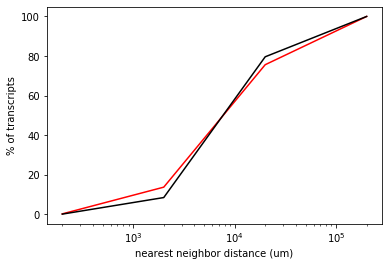

In [34]:
import matplotlib.pyplot as plt
import collections

thresholds = {200:0.13382795187882354, 2000:13.649713966372472, 20000: 75.58820427887294, 200000: 100.0}
random_thresholds = {200: 0.010495166321788237, 2000: 8.391300996998295, 20000: 79.58979494157295, 200000: 100.0}
fig, ax = plt.subplots()

#plt.plot( 'x', 'y1', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)

ax.semilogx(list(thresholds), list(thresholds.values()), color = 'red')
ax.semilogx(list(random_thresholds), list(random_thresholds.values()), color = 'black')
#plt.plot(list(thresholds), list(thresholds.values()))
plt.ylabel('% of transcripts')
plt.xlabel('nearest neighbor distance (um)')
plt.show()

In [4]:
thresholds = {200: 0.13382795187882354, 2000: 13.649713966372472, 200000: 100.0, 20000: 75.58820427887294}

In [36]:

np.random.rand(3,2)

array([[0.79266327, 0.0767705 ],
       [0.24394331, 0.53484753],
       [0.20680069, 0.0228853 ]])

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

test_file = pd.read_csv('codetection_stats.csv', header=0)
thresholds = dict.fromkeys(set(test_file['threshold']), 0) 

for threshold in thresholds.keys():
    codetect = []
    for index, row in test_file.iterrows(): 
        if row['threshold'] == threshold:
            codetect.append(row['co_detect'])
    mean_codetect = np.mean(codetect)
    thresholds.update({threshold: mean_codetect})


plt.plot(list(thresholds),list(thresholds.values()))
plt.ylabel('some numbers')
plt.show()

ModuleNotFoundError: No module named 'pandas'

In [40]:
import numpy as np
xpos_targ = [1,2,3,4,5]
ypos_targ = [5,4,3,2,1]
zpos_targ = [1,3,5,2,4]
target_df = np.column_stack((xpos_targ,ypos_targ,zpos_targ))
print (target_df.shape)
np.random.rand(target_df.shape)
print (target_df)
np.random.shuffle(target_df)
print (target_df)
print (random)

(5, 3)


TypeError: 'tuple' object cannot be interpreted as an integer